**Notebook information:**

This notebook is designed to reproduce (re-generate) the figures (Python version) provided in the main manuscript and supplementary materials. A separate R-codebase is used to modify (improve) these figures. We will assume at least the following: (0) The data is available in relevant directories; (1) The Camformer models are trained in cases where the code loads a saved model; (3) Base code libraries are available within "./base". The generated figures (and sometimes, their associated data) will be saved into "manuscript/". Due to the size constraints, we are not able to upload the raw datasets, but we have made efforts to list them or provide their URLs. 

For additional clarity, reach out to the authors: [Tirtharaj Dash](mailto:td522@cam.ac.uk) or [Susanne Bornelöv](mailto:smb208@cam.ac.uk).

**Set the environment for the codes to run (see `env.yml`); Then, include the relevant libraries as below.**

In [1]:
FIG_PATH = "./manuscript"

In [2]:
import sys
sys.path.append('./base')

In [3]:
import os
import re
from importlib import reload
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from pandas.plotting import parallel_coordinates
from torchsummary import summary

from base import plot_utils

from base.plot_utils import (
    plot_box_and_whisker, plot_nice_scatter, plot_annotated_scatter, plot_box_plots_avg, plot_radar_plots_avg, gen_ensemble_boxplots_unscaled,
    trainingdata_vs_perfs_allseeds, generate_bootstrap_violin_plots)
from base.eval_utils import calculate_eval_metrics
from base.utils import my_pearsonr, my_spearmanr, createDataLoader
from base.run_utils import loadDict, setSeeds

from base.model import CNN #For large (original) model
#from base.model_basic import CNN #For small (or mini) model

from base.model_utils import predict
from base.results_utils import read_scores, getFinalScores

**Fig 2. Showing the Camformer-original model structure**

In [9]:
from base.model import CNN
config = loadDict(path="./training_results_tr0.9/9_onehot_L1_AdamW_ReduceLROnPlateau/42", filename="config")
setSeeds(config["seed"])

df = pd.read_csv("data/1K/train_sequences.txt", delimiter="\t", names=["seq","expr"])
seqs, exprs = df[["seq"]], df["expr"]
TestLoader = createDataLoader(seq=seqs, expr=exprs, config=config)

model_args = config["model_args"]
model = CNN(**model_args)
model = torch.load(config["best_model_path"])

print("Camformer (Original) model structure:")
summary(model, input_size=(4,110,1))
model = None

Random seed set to 42; Cudnn benchmarking is False.
Number of sequences passed to encode	: 1000
Dropped due to more N count (> 3)	: 6
Dropped due to outside length spec	: 19

Camformer (Original) model structure:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 512, 110, 1]          20,992
        Conv2dSame-2          [-1, 512, 110, 1]               0
       BatchNorm2d-3          [-1, 512, 110, 1]           1,024
              ReLU-4          [-1, 512, 110, 1]               0
         MaxPool2d-5          [-1, 512, 110, 1]               0
           Dropout-6          [-1, 512, 110, 1]               0
            Conv2d-7          [-1, 512, 110, 1]       2,621,952
        Conv2dSame-8          [-1, 512, 110, 1]               0
       BatchNorm2d-9          [-1, 512, 110, 1]           1,024
             ReLU-10          [-1, 512, 110, 1]               0
        MaxPool2d-

Camformer-Original:


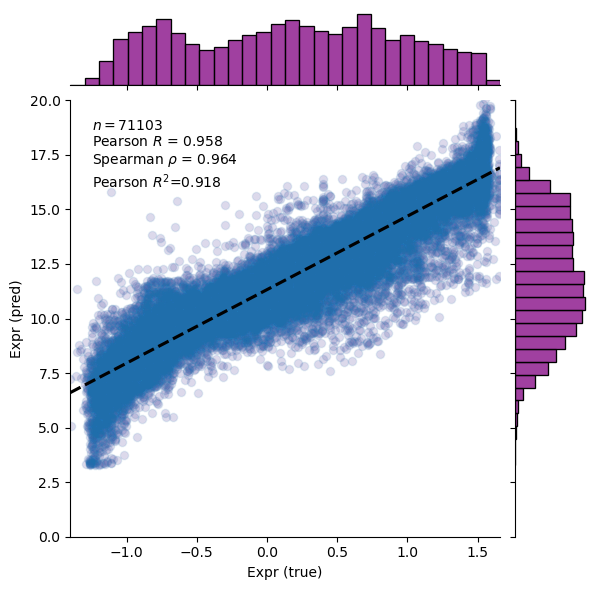

Camformer-Mini:


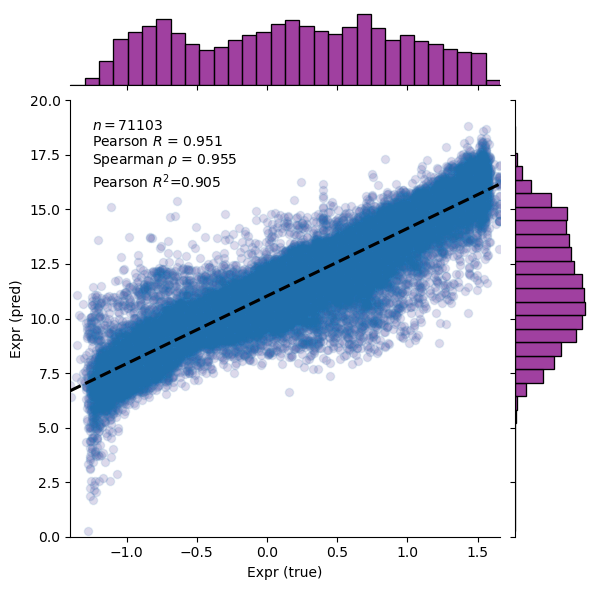

In [8]:
#Original model
print("Camformer-Original:")
ground_truth_file = "./OfficialEval/filtered_test_data_with_MAUDE_expression.txt"
pred_file = "./testing_results_tr0.9/challenge_testset_final_models/9_onehot_L1_AdamW_ReduceLROnPlateau/42/seq_predexpr.csv"

df = pd.read_csv(ground_truth_file, header=None, delimiter="\t", names=["seq","expr"])
df_hat = pd.read_csv(pred_file, header=None, delimiter="\t", names=["seq","expr"])

x = df["expr"]
y = df_hat["expr"]

plot_nice_scatter(x=x, y=y, normalise=False, ylims=[0,20])

#Mini model
print("Camformer-Mini:")
pred_file = "./testing_results_tr0.9/challenge_testset_final_models/219_onehotWithP_MSE_AdamW_ReduceLROnPlateau/42/seq_predexpr.csv"

df = pd.read_csv(ground_truth_file, header=None, delimiter="\t", names=["seq","expr"])
df_hat = pd.read_csv(pred_file, header=None, delimiter="\t", names=["seq","expr"])

x = df["expr"]
y = df_hat["expr"]

plot_nice_scatter(x=x, y=y, normalise=False, ylims=[0,20])

**Fig S2. Coloured scatter plot between ground truth expressions and predicted expressions from Camformer-orig model**

Random seed set to 42; Cudnn benchmarking is False.
Number of sequences passed to encode	: 63814
Dropped due to more N count (> 3)	: 0
Dropped due to outside length spec	: 0

Data saved to ./manuscript/coloured_scatter_privatete_SI.csv


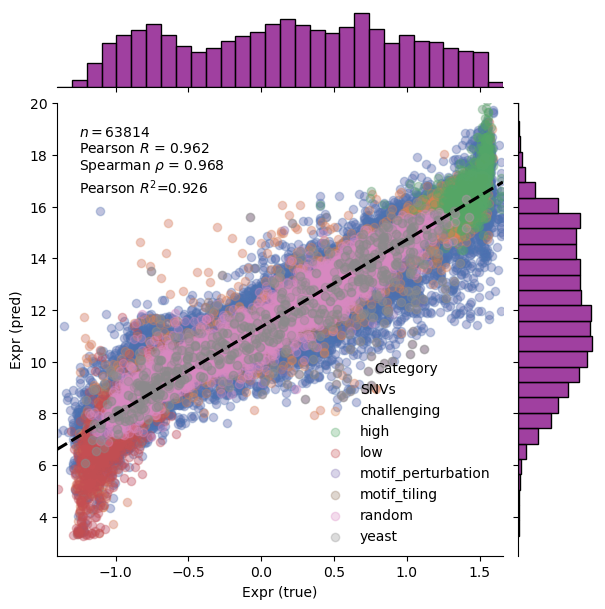

In [10]:
ground_truth_file = "./OfficialEval/filtered_test_data_with_MAUDE_expression_annotated.txt"
df = pd.read_csv(ground_truth_file, delimiter=",")
df = df[df["split"] == "private"]
seq = df[["seq"]]
expr = df["expr"]

from base.model import CNN    
config = loadDict(path="./training_results_tr0.9/9_onehot_L1_AdamW_ReduceLROnPlateau/42", filename="config")
setSeeds(config["seed"])
TestLoader = createDataLoader(seq=seq, expr=expr, config=config)

model_args = config["model_args"]
model = CNN(**model_args)
model = torch.load(config["best_model_path"])
model.to(config["device"])
model.eval()

y_pred, y_true = predict(model=model, DataLoader=TestLoader, config=config)
plot_annotated_scatter(x=y_true, y=y_pred, categories=df["category"], normalise=False, ylims=[2.5, 20], save_as=f"{FIG_PATH}/coloured_scatter_privatete_SI")

**Fig 2 (b,c): Ensemble predictions from all Camformer models for both Original and Mini variants**

In [17]:
true_file = "OfficialEval/filtered_test_data_with_MAUDE_expression.txt"
df_true = pd.read_csv(true_file, delimiter="\t", header=None)
df_true.columns = ["seq", "expr"]
Y_true = df_true["expr"].values

print("Camformer-original model (Predictions from all replicates)")
df_all_preds = pd.DataFrame({"Y_true": Y_true})
pred_dir = "testing_results_tr0.9/challenge_testset_final_models/9_onehot_L1_AdamW_ReduceLROnPlateau"
SEEDS = [42, 23, 47, 56, 89, 12, 34, 78, 67, 98]
for seed in SEEDS:
    file_path = f"{pred_dir}/{seed}/seq_predexpr.csv"
    df_pred = pd.read_csv(file_path, delimiter="\t", header=None)
    df_all_preds[f"pred_{seed}"] = df_pred.iloc[:, 1].values
df_all_preds.to_csv(f"{FIG_PATH}/Fig3_Camformer_orig_allrepl_preds.csv", index=False)
display(df_all_preds.head(2))

print("Camformer-original model (Predictions from all replicates)")
df_all_preds = pd.DataFrame({"Y_true": Y_true})
pred_dir = "testing_results_tr0.9/challenge_testset_final_models/219_onehotWithP_MSE_AdamW_ReduceLROnPlateau"
SEEDS = [42, 23, 47, 56, 89, 12, 34, 78, 67, 98]
for seed in SEEDS:
    file_path = f"{pred_dir}/{seed}/seq_predexpr.csv"
    df_pred = pd.read_csv(file_path, delimiter="\t", header=None)
    df_all_preds[f"pred_{seed}"] = df_pred.iloc[:, 1].values
df_all_preds.to_csv(f"{FIG_PATH}/Fig3_Camformer_mini_allrepl_preds.csv", index=False)
display(df_all_preds.head(2))
print(f"Dimension of the full dataframe: {df_all_preds.shape}")

Camformer-original model (Predictions from all replicates)


,Y_true,pred_42,pred_23,pred_47,pred_56,pred_89,pred_12,pred_34,pred_78,pred_67,pred_98
0,0.156331,11.462335,11.255583,11.039259,12.048164,11.665944,11.511631,12.155991,11.686829,11.279459,10.768657
1,0.711710,11.942212,11.699289,11.033443,11.754566,12.332068,11.527268,11.963156,11.740564,11.611901,11.369064


Camformer-original model (Predictions from all replicates)


,Y_true,pred_42,pred_23,pred_47,pred_56,pred_89,pred_12,pred_34,pred_78,pred_67,pred_98
0,0.156331,10.893118,11.118553,12.028330,11.741215,10.629566,10.424972,11.341846,12.243439,11.468523,10.729000
1,0.711710,11.355280,11.430893,11.730852,11.620914,10.789849,10.630764,11.328515,12.111215,11.337832,11.028889


Dimension of the full dataframe: (71103, 11)


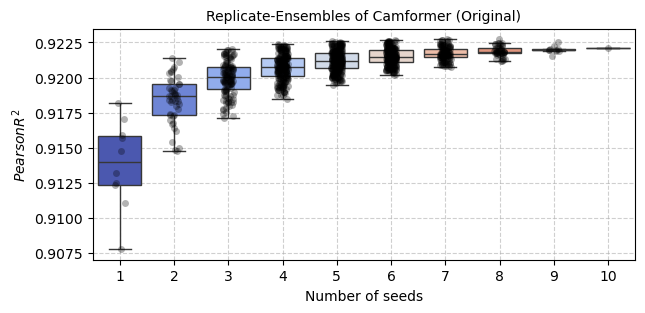

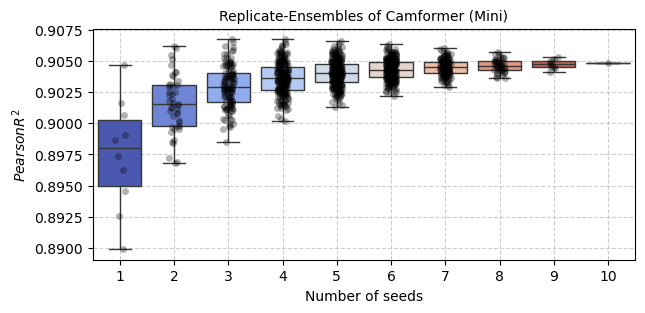

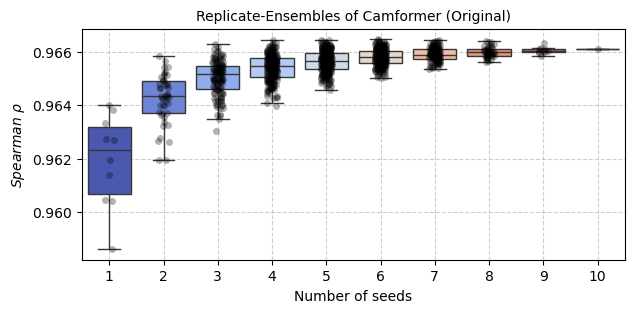

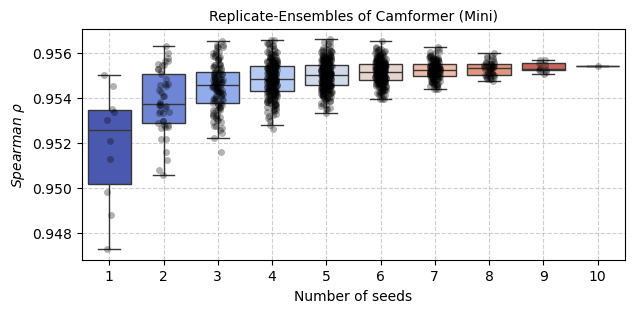

In [14]:
choices = ["PearsonR2", "SpearmanR"]

# Load ground truth expressions
true_file = "OfficialEval/filtered_test_data_with_MAUDE_expression.txt"
df_true = pd.read_csv(true_file, delimiter="\t", header=None)
df_true.columns = ["seq", "expr"]
Y_true = df_true["expr"].values

for choice in choices:
    ### Load predicted expressions from the Original model
    pred_dir = "testing_results_tr0.9/challenge_testset_final_models/9_onehot_L1_AdamW_ReduceLROnPlateau"
    SEEDS = [42, 23, 47, 56, 89, 12, 34, 78, 67, 98]
    df_preds = [pd.read_csv(f"{pred_dir}/{seed}/seq_predexpr.csv", delimiter="\t", header=None) for seed in SEEDS]
    Y_preds = [df_pred.iloc[:, 1].values for df_pred in df_preds]

    gen_ensemble_boxplots_unscaled(Y_preds=Y_preds, Y_true=Y_true, model_type="Original", choice=choice)

    ### Load predicted expressions for the Mini model
    pred_dir = "testing_results_tr0.9/challenge_testset_final_models/219_onehotWithP_MSE_AdamW_ReduceLROnPlateau"
    SEEDS = [42, 23, 47, 56, 89, 12, 34, 78, 67, 98]
    df_preds = [pd.read_csv(f"{pred_dir}/{seed}/seq_predexpr.csv", delimiter="\t", header=None) for seed in SEEDS]
    Y_preds = [df_pred.iloc[:, 1].values for df_pred in df_preds]

    gen_ensemble_boxplots_unscaled(Y_preds=Y_preds, Y_true=Y_true, model_type="Mini", choice=choice)

**Raw figures for Fig S5,S6. Comparing different Camformer variants across hyperparameters**

20
Model


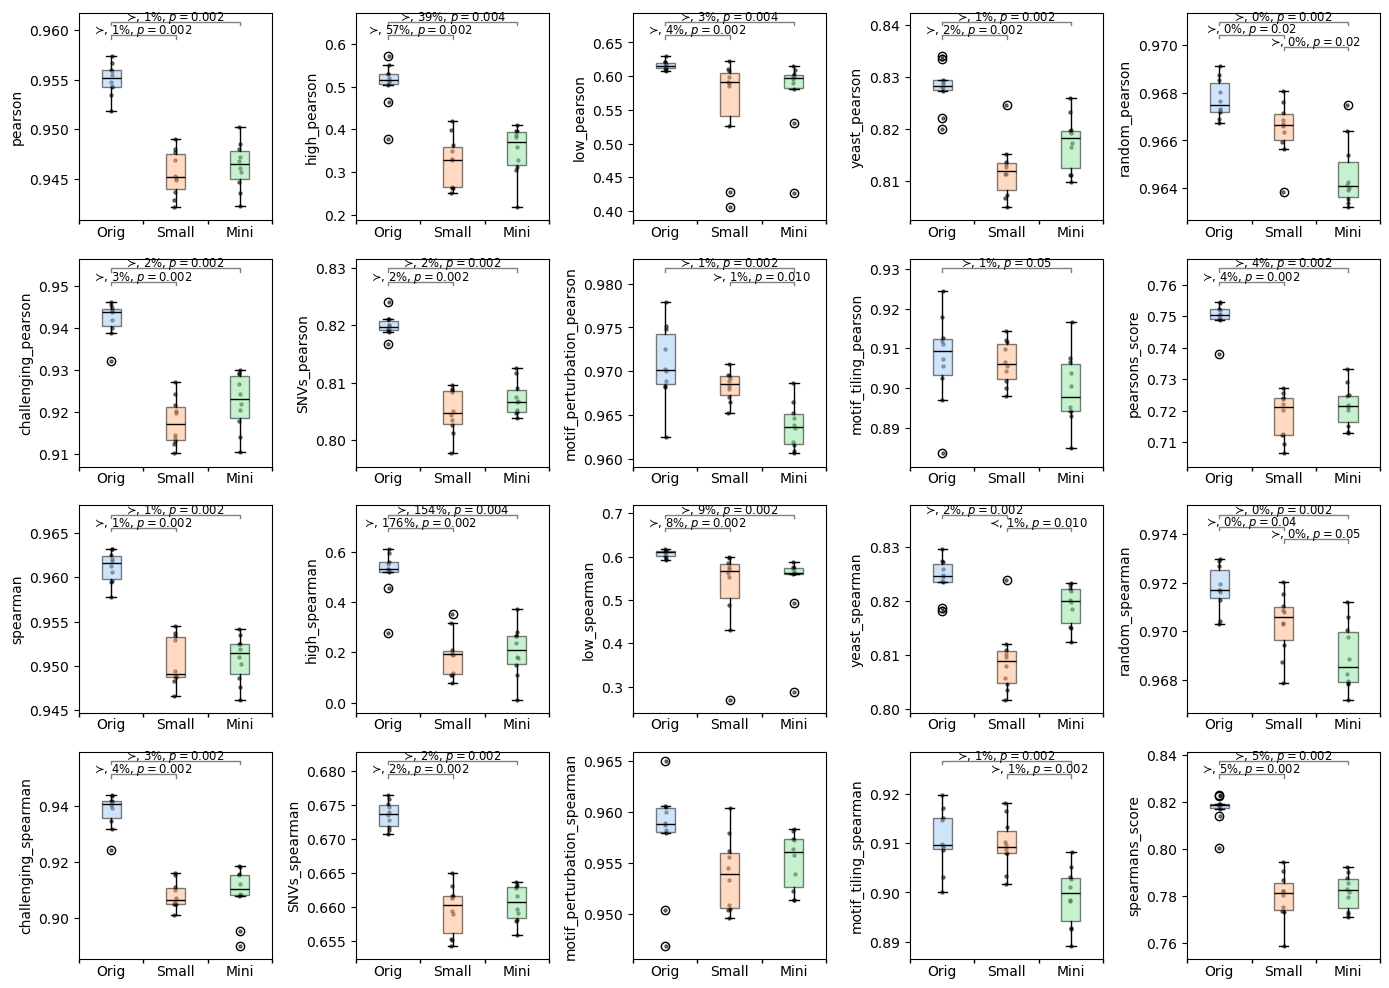

In [15]:
metrics = ["pearson", "high_pearson", "low_pearson", "yeast_pearson", "random_pearson", "challenging_pearson", "SNVs_pearson", 
           "motif_perturbation_pearson", "motif_tiling_pearson", "pearsons_score",
           "spearman", "high_spearman", "low_spearman", "yeast_spearman", "random_spearman", "challenging_spearman", "SNVs_spearman", 
           "motif_perturbation_spearman", "motif_tiling_spearman", "spearmans_score"]
print(len(metrics))

df_pub, df_pvt = getFinalScores()
columns = metrics

df = df_pvt

fig, axs = plt.subplots(4, 5, figsize=(14, 10))

box_group = "Model"
print(box_group)

order = [3,4,2]

for i, col in enumerate(columns):
    target = col

    df_subset = df[[box_group, target]]
    
    groupby_obj = df.groupby(box_group, sort=False)
    data = [group[target].to_numpy() for _, group in groupby_obj]
    labels = [label for label, _ in groupby_obj]

    data = [data[k] for k in order]
    labels = [labels[k] for k in order]

    title = ""
    ylabel = target
    
    # Use correct subplot index
    ax = axs[i // 5, i % 5]
    ax.set_title(target)  # Set subplot title
    xticklabels = labels
    _, _ = plot_box_and_whisker(data, title, ylabel, xticklabels, show_n=False, show_p=True, show_swarmplot=True, filepath=None, ax=ax)

plt.tight_layout()
plt.show()

Box plots comparing Camformer and LegNet:


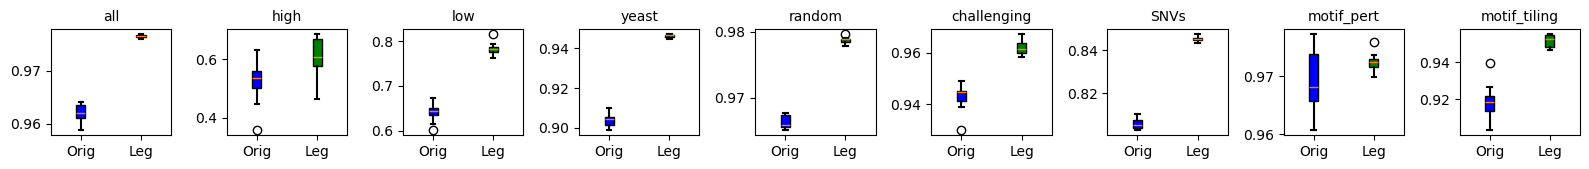

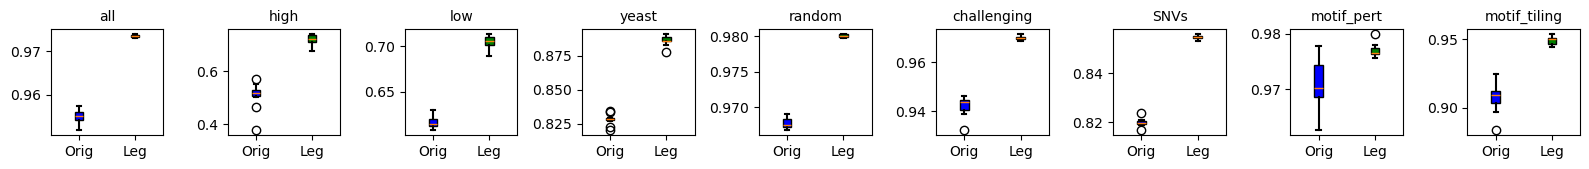

In [16]:
df_pub, df_pvt = getFinalScores()

print("Box plots comparing Camformer and LegNet:")
plot_box_plots_avg(df=df_pub, title="Public")
plot_box_plots_avg(df=df_pvt, title="Private")

**Fig S7. Radar plot showing performance of Camformer variants across the 8 different evaluation metrics**

Radar plots comparing all models:


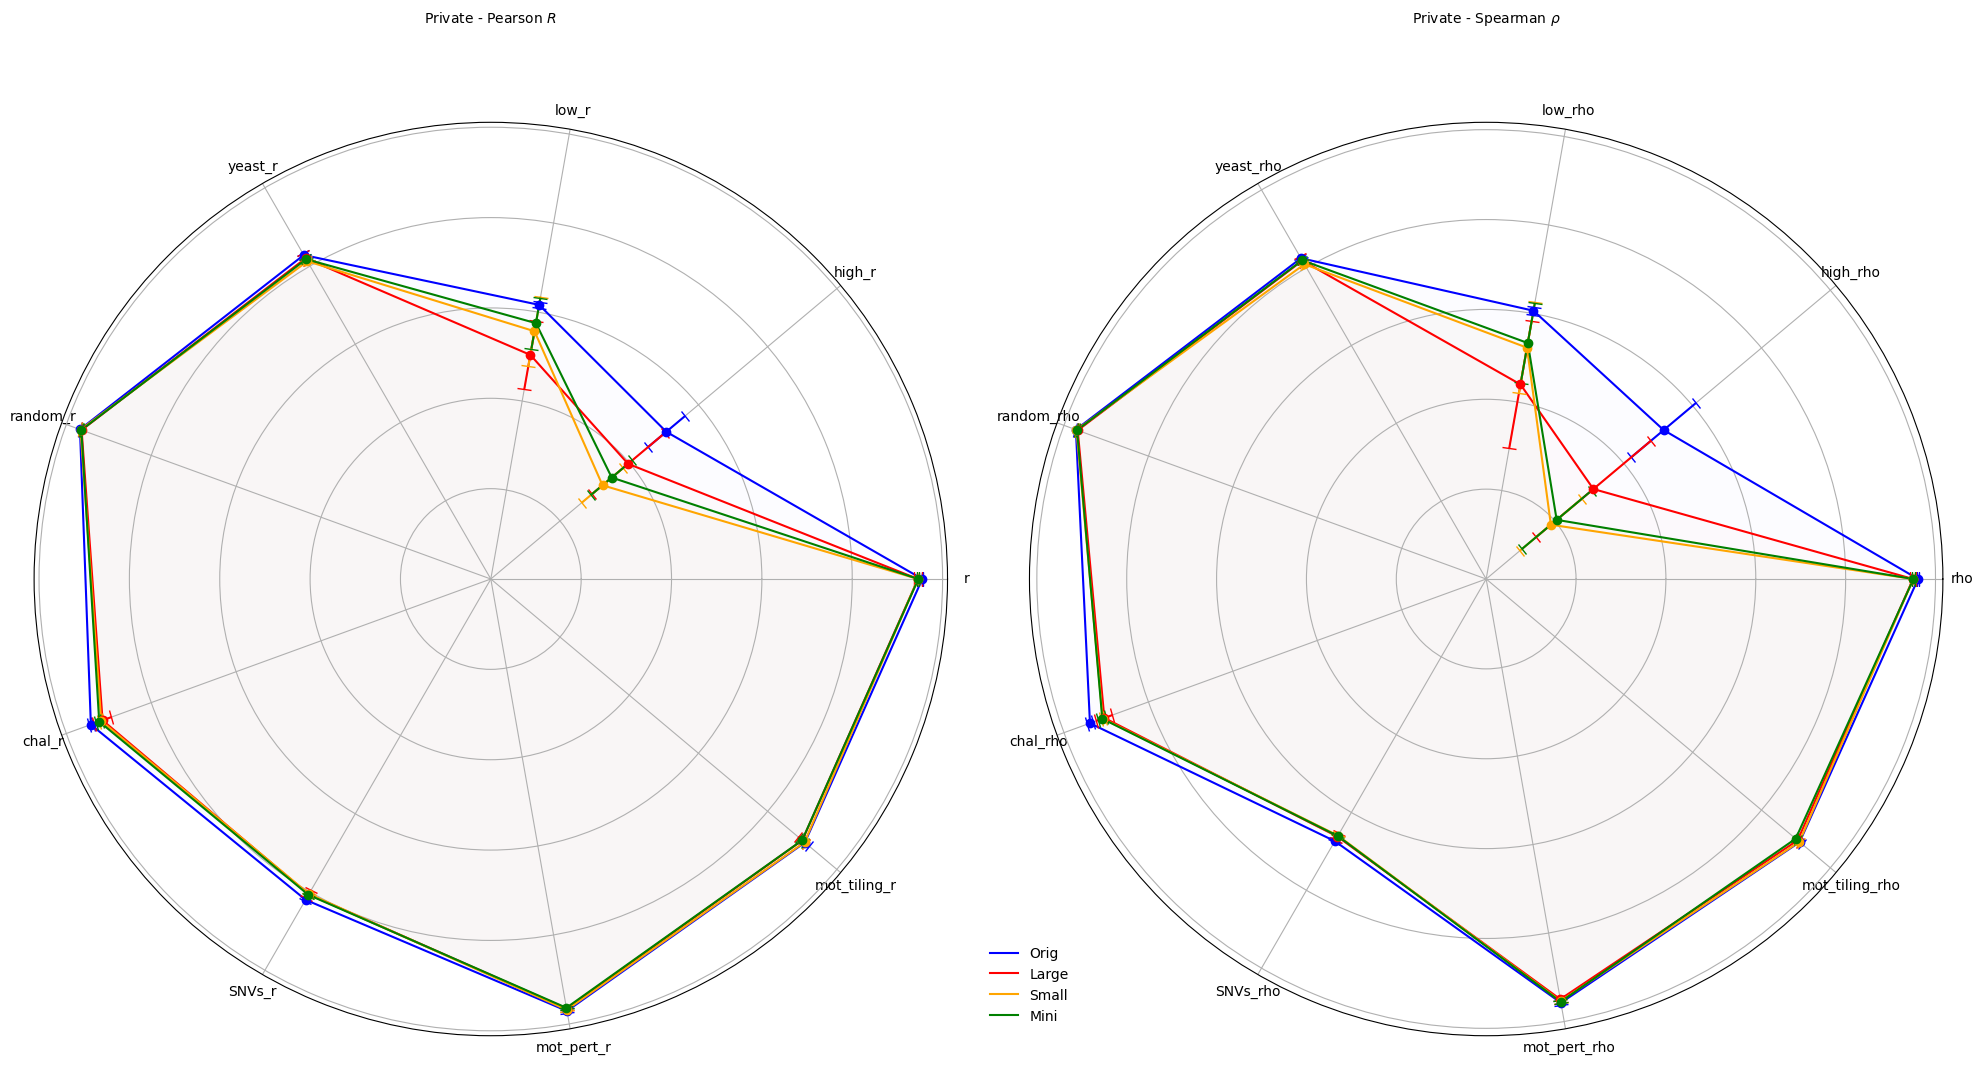

In [12]:
print("Radar plots comparing all models:")
df_pub, df_pvt = getFinalScores()
plot_radar_plots_avg(df=df_pvt, title="Private")

**Fig S8. Box plot showing model performance as a function of training data size.**

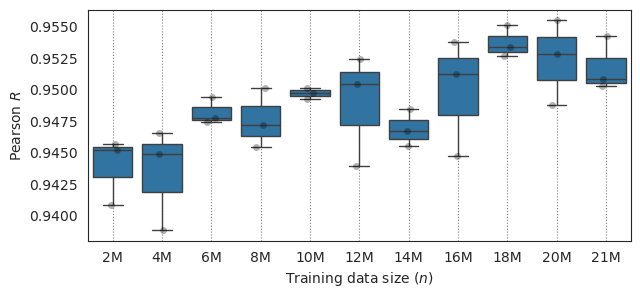

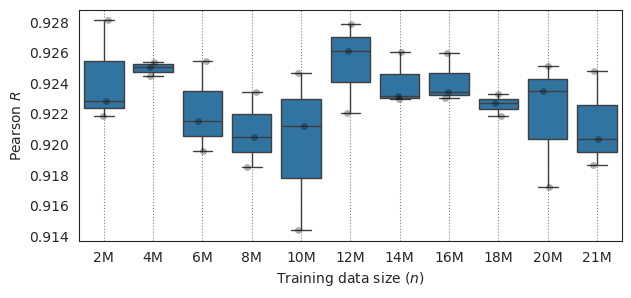

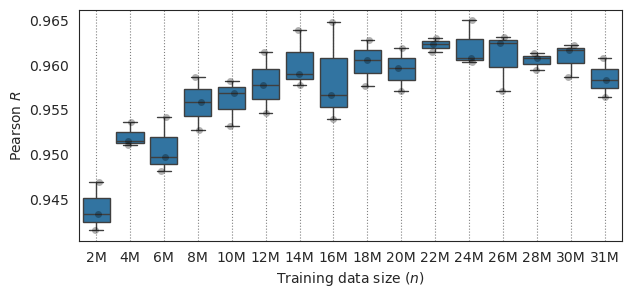

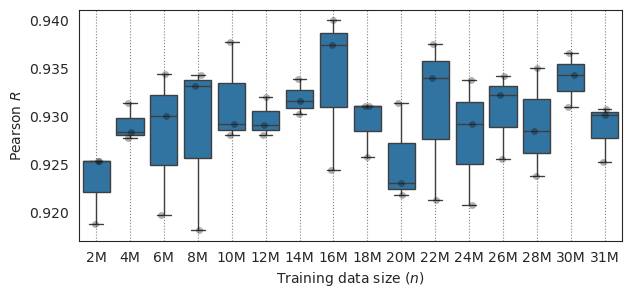

In [22]:
reload(plot_utils)

original_stdout = sys.stdout
sys.stdout = open(os.devnull, 'w')

print("Dataset: Native_defined")
trainingdata_vs_perfs_allseeds(input_file="data/media/LegNet_eval/Native_defined.csv", 
                               parent_dir="training_results_media_tr0.9/defined_media_training_data_SC_Ura/9_onehot_L1_AdamW_ReduceLROnPlateau",
                               save_as=f"{FIG_PATH}/Fig_S8_Native_defined_Camformer_trn_seeds")

trainingdata_vs_perfs_allseeds(input_file="data/media/LegNet_eval/Native_defined.csv", 
                               parent_dir="training_results_media_tr0.9/defined_media_training_data_SC_Ura/219_onehotWithP_MSE_AdamW_ReduceLROnPlateau",
                               save_as=f"{FIG_PATH}/Fig_S8_Native_defined_Camformer-Mini_trn_seeds")

print("Dataset: Native_complex")
trainingdata_vs_perfs_allseeds(input_file="data/media/LegNet_eval/Native_complex.csv", 
                               parent_dir="training_results_media_tr0.9/complex_media_training_data_Glu/9_onehot_L1_AdamW_ReduceLROnPlateau",
                               save_as=f"{FIG_PATH}/Fig_S8_Native_complex_Camformer_trn_seeds")

trainingdata_vs_perfs_allseeds(input_file="data/media/LegNet_eval/Native_complex.csv", 
                               parent_dir="training_results_media_tr0.9/complex_media_training_data_Glu/219_onehotWithP_MSE_AdamW_ReduceLROnPlateau",
                               save_as=f"{FIG_PATH}/Fig_S8_Native_complex_Camformer-Mini_trn_seeds")

sys.stdout.close()
sys.stdout = original_stdout

**Fig 6. Boot-strapped performance of different models, comparing Camformers against state-of-the-art models**

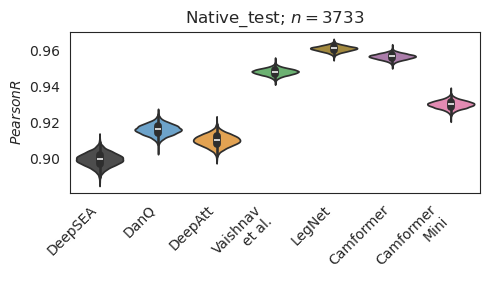

In [24]:
model_pred_files = {
    'DeepSEA': "~/SBLab/evolution/manuscript_code/model/results_summary/Native_test_DeepSEA_model.csv",
    'DanQ': "~/SBLab/evolution/manuscript_code/model/results_summary/Native_test_DanQ_model.csv",
    'DeepAtt': "~/SBLab/evolution/manuscript_code/model/results_summary/Native_test_DeepAtt_model.csv",
    'Vaishnav\net al.': "~/SBLab/evolution/manuscript_code/model/results_summary/Native_test_gpu_model.csv",
    'LegNet':"./data/media/LegNet_eval/Native_complex_matchingseqs.csv",
    'Camformer': "./results/Camformer_predictions/Native_test_Camformer_model.csv",
    'Camformer\nMini': "./results/Camformer_predictions/Native_test_Camformer-Mini_model.csv"
}

#set n_bootstra=10000, for reproducing fig in the paper; It takes approx 2 minutes
generate_bootstrap_violin_plots(model_pred_files, n_bootstrap=10000, fig_title="Native_test", save_dir=f"{FIG_PATH}")

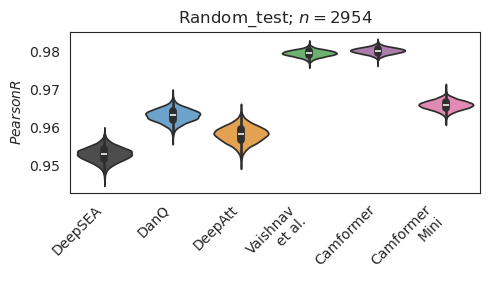

In [25]:
model_pred_files = {
    'DeepSEA': "~/SBLab/evolution/manuscript_code/model/results_summary/Random_test_DeepSEA_model.csv",
    'DanQ': "~/SBLab/evolution/manuscript_code/model/results_summary/Random_test_DanQ_model.csv",
    'DeepAtt': "~/SBLab/evolution/manuscript_code/model/results_summary/Random_test_DeepAtt_model.csv",
    'Vaishnav\net al.': "~/SBLab/evolution/manuscript_code/model/results_summary/Random_test_gpu_model.csv",
    'Camformer': "./results/Camformer_predictions/Random_test_Camformer_model.csv",
    'Camformer\nMini': "./results/Camformer_predictions/Random_test_Camformer-Mini_model.csv"
}

#set n_bootstra=10000, for reproducing fig in the paper; It takes approx 2 minutes
generate_bootstrap_violin_plots(model_pred_files, n_bootstrap=10000, fig_title="Random_test", save_dir=f"{FIG_PATH}")

**Fig 7 and S9. Showing t-SNE embeddings from Camformer at various layers**

In [26]:
import numpy as np
from base.plot_utils import scale_predictions
from base.emb_utils import plot_hist_tsne

In [27]:
#Check if the sampled file exists
file_path = "./stored_embs/sampled_data.csv"

if os.path.exists(file_path):
    print(f"The file '{file_path}' exists. So, just running visualisation.")
    df_sampled = pd.read_csv(file_path)
    num_quantiles = len(df_sampled["quantile"].unique())
    df_sampled["quantile"] = pd.Categorical(df_sampled["quantile"], categories=[f'Q{i+1}' for i in range(num_quantiles)], ordered=True)
else:
    print(f"The file '{file_path}' does not exist. Re-running the Camformer embeddings extraction.")
    df = pd.read_csv("OfficialEval/filtered_test_data_with_MAUDE_expression.txt", header=None, names=["seq","expr"], delimiter="\t")
    df_sampled = df.sample(n=10000, random_state=42)
    num_quantiles = 6
    df_sampled["quantile"], bins = pd.qcut(df_sampled["expr"], num_quantiles, labels=[f'Q{i+1}' for i in range(num_quantiles)], retbins=True)
    print(f"Quantile bins: {bins}")
    today_date = datetime.now().strftime("%Y-%m-%d")
    df_sampled.to_csv(f"./stored_embs/sampled_data_{today_date}.csv", index=False)

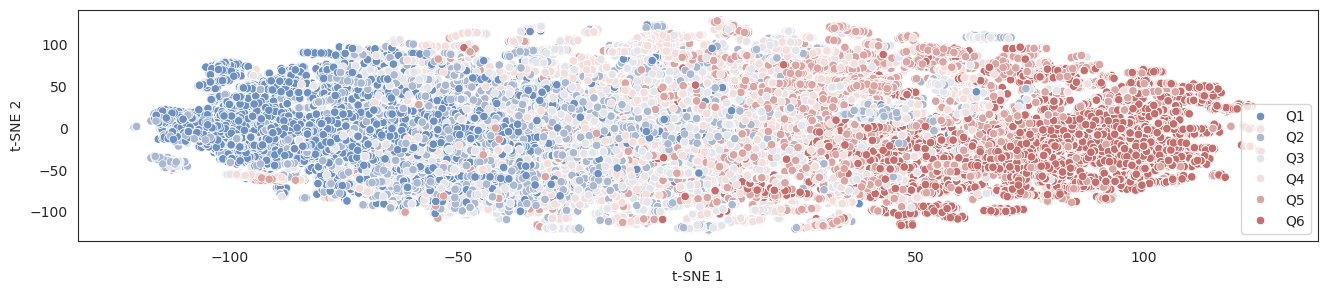

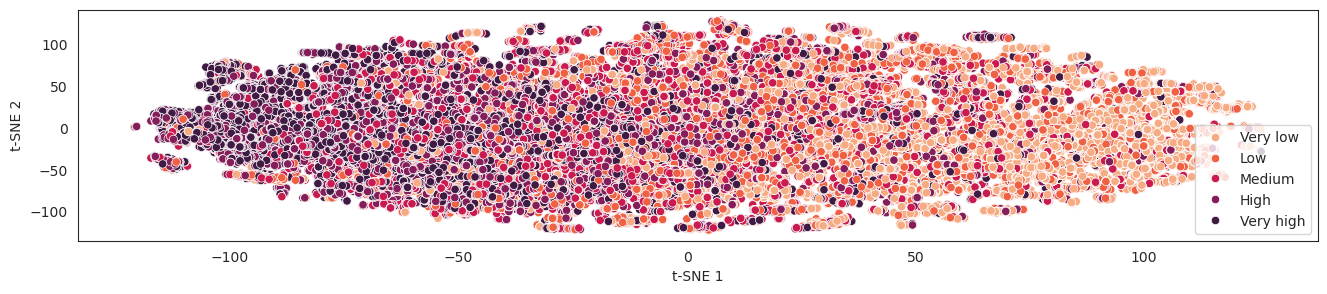

In [28]:
### t-SNE plots with CNN embeddings (Conv Layers: flattened) with legends: (1) Quantiles of expressions; (2) Quantiles of prediction errors
error_categories = ["Very low", "Low", "Medium", "High", "Very high"]
run = True

if run:
    all_y = []
    all_y_pred = []

    for (X, y) in TestLoader:
        all_y.append(y.numpy())
        all_y_pred.append(y_pred[:len(y)])

    all_y = np.concatenate(all_y)
    all_y_pred = np.concatenate(all_y_pred)

    global_errors = np.abs(all_y_pred - all_y)

    num_quantiles = 6  
    quantile_labels = [f'Q{i+1}' for i in range(num_quantiles)]

    global_y_quantiles, y_quantile_edges = pd.qcut(all_y, num_quantiles, labels=quantile_labels, retbins=True)
    global_error_quantiles, error_quantile_edges = pd.qcut(global_errors, len(error_categories), labels=error_categories, retbins=True)

    print(f"Prediction quantile edges: {y_quantile_edges}")
    print(f"Error quantile edges     : {error_quantile_edges}")

    for layer_idx in [5]:  # range(len(model.CNN_layers))
        layer_output = []
        quantiles = []
        error_class = []
    
        for (X, y) in TestLoader:
            output = X.to(config['device'])
    
            for i, layer in enumerate(model.CNN_layers):
                if i > layer_idx:
                    break
                output = layer(output)
            
            output_cpu = output.cpu().detach()
            layer_output.append(output_cpu)
    
            y_pred_batch = y_pred[:len(y)] 
            y_pred_error = np.abs(np.array(y_pred_batch) - np.array(y))  # error

            quantiles.extend(pd.cut(y, bins=y_quantile_edges, labels=quantile_labels, include_lowest=True))
            error_class.extend(pd.cut(y_pred_error, bins=error_quantile_edges, labels=error_categories, include_lowest=True))
                
        stacked_layer_outputs = torch.cat(layer_output, dim=0)
        
        print(f"Conv Layer {layer_idx} output shape: {stacked_layer_outputs.shape}, "
              f"Errors length: {len(error_class)}, Quantile length: {len(quantiles)}")
    
        quantiles = pd.Categorical(quantiles, categories=quantile_labels, ordered=True)
        error_class = pd.Categorical(error_class, categories=error_categories, ordered=True)
        
        plot_hist_tsne(stacked_layer_outputs, quantiles, layer="conv", plot_hist=False, plot_tsne=True, color_palette="vlag")
        plot_hist_tsne(stacked_layer_outputs, error_class, layer="conv", plot_hist=False, plot_tsne=True)

**Fig S10,S11. Supporting codebase Grad-CAM visualisations**: Showing here a single sequence execution.

In [9]:
from base.gradcam_utils import plot_layerwise_logo

In [10]:
config = loadDict(path="training_results_tr0.9/9_onehot_L1_AdamW_ReduceLROnPlateau/42") #Camformer Original
setSeeds(config["seed"])
model_args = config["model_args"]
model = CNN(**model_args)
model = torch.load(config["best_model_path"])
model.to(config["device"])
model.eval()

Random seed set to 42; Cudnn benchmarking is False.


CNN(
  (CNN_layers): ModuleList(
    (0): Sequential(
      (0): Conv2dSame(
        (conv): Conv2d(4, 512, kernel_size=(10, 1), stride=(1, 1))
      )
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=[1, 1], stride=[1, 1], padding=0, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.3, inplace=False)
    )
    (1-3): 3 x Sequential(
      (0): Conv2dSame(
        (conv): Conv2d(512, 512, kernel_size=(10, 1), stride=(1, 1))
      )
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=[1, 1], stride=[1, 1], padding=0, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.3, inplace=False)
    )
    (4): Sequential(
      (0): Conv2dSame(
        (conv): Conv2d(512, 512, kernel_size=(10, 1), stride=(1, 1))
      )
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

Number of sequences passed to encode	: 1
Dropped due to more N count (> 3)	: 0
Dropped due to outside length spec	: 0

Layer 5


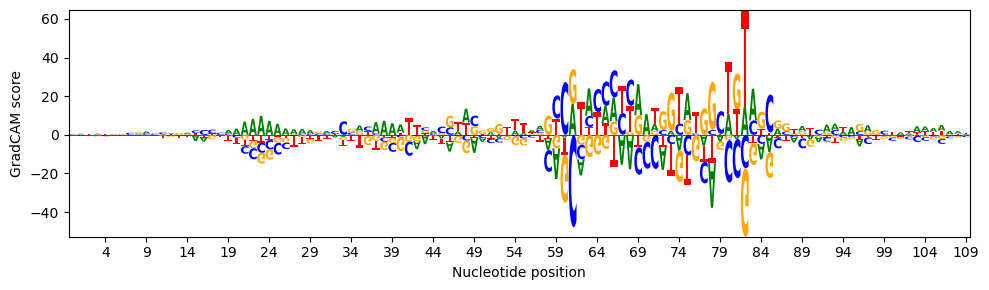

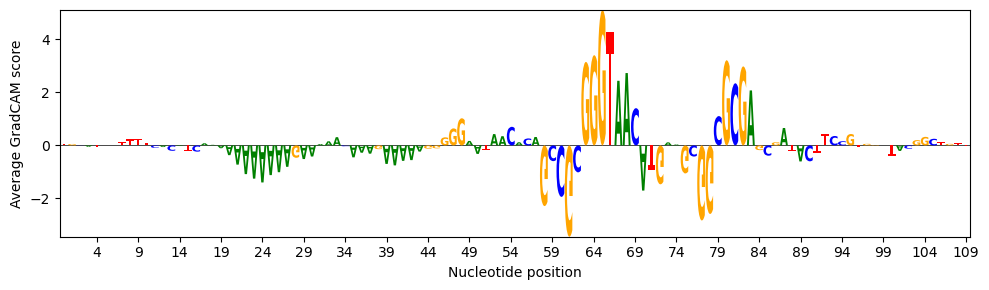

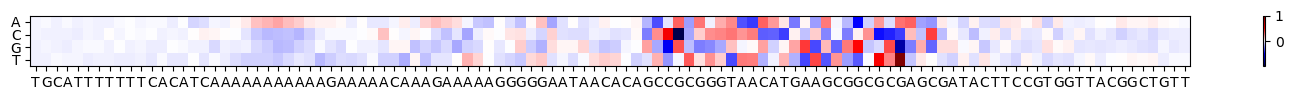

In [11]:
df = pd.DataFrame(columns=["seq","expr"])
df["seq"] = ["TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAACAAAGAAAAAGGGGGAATAACACAGCCGCGGGTAACATGAAGCGGCGCGAGCGATACTTCCGTGGTTACGGCTGTT"]
df["expr"] = [0.966727069012904]
config["batch_size"] = 1
TestLoader = createDataLoader(df[["seq"]], df["expr"], config=config, isTest=True)
plot_layerwise_logo(model, config, TestLoader, layer_idx=5, num_samples=1)

**Fig s13. In silico mutagenesis (ISM) visualisations**: Showing here an execution for a single sequence

In [12]:
from base.ism_utils import generate_mutations, generate_logo_w_flanking

240 mutations for sequence: TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAACAAAGAAAAAGGGGGAATAACACAGCCGCGGGTAACATGAAGCGGCGCGAGCGATACTTCCGTGGTTACGGCTGTT [0.97]
Generating ISM logos for: TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAACAAAGAAAAAGGGGGAATAACACAGCCGCGGGTAACATGAAGCGGCGCGAGCGATACTTCCGTGGTTACGGCTGTT
Number of sequences passed to encode	: 1
Dropped due to more N count (> 3)	: 0
Dropped due to outside length spec	: 0

Number of sequences passed to encode	: 240
Dropped due to more N count (> 3)	: 0
Dropped due to outside length spec	: 0



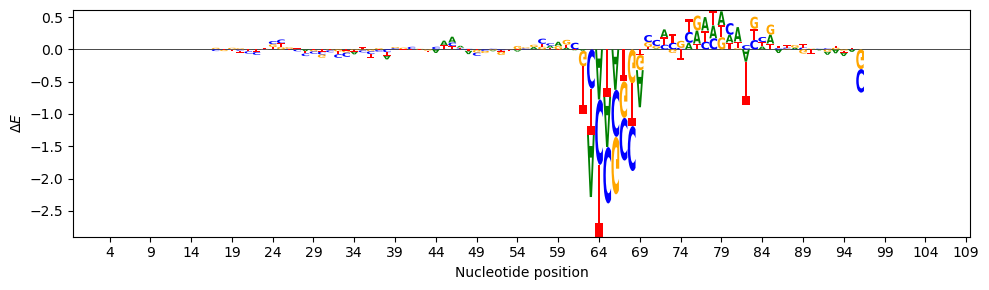

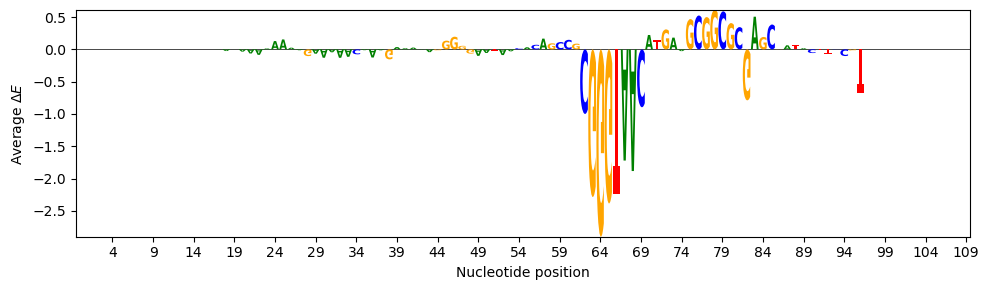

True

In [13]:
seq, expr = "TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAACAAAGAAAAAGGGGGAATAACACAGCCGCGGGTAACATGAAGCGGCGCGAGCGATACTTCCGTGGTTACGGCTGTT", 0.966727069012904

mutations = generate_mutations(seq)
print(f"{len(mutations)} mutations for sequence: {seq} [{expr:.2f}]")
generate_logo_w_flanking(model, config, seq, expr, entropy_thres=7)